In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# Load the dataset

train_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 (required for ResNet-34)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

train_dataset = datasets.ImageFolder(train_data_path, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_data_path, transform=data_transforms)
valid_dataset = datasets.ImageFolder(valid_data_path, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)


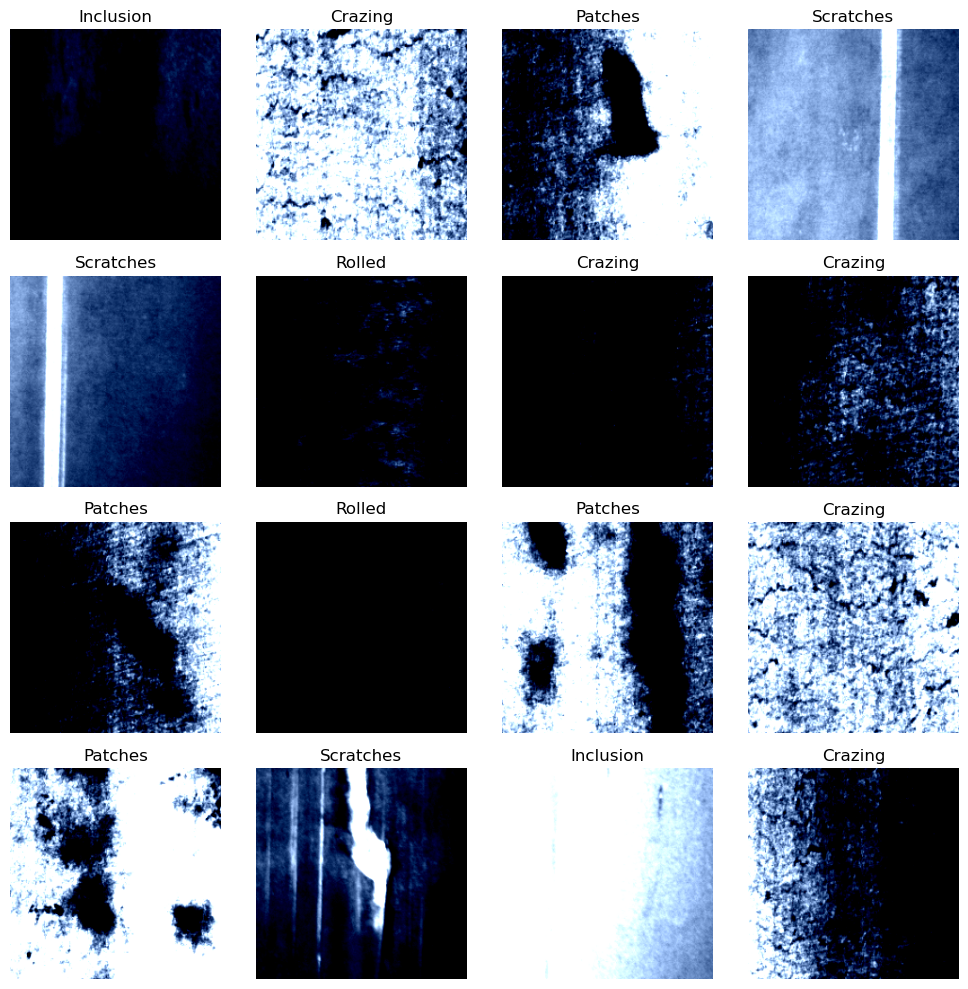

In [13]:
# Function to plot a grid of images
def imshow_grid(images, labels, classes, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        img = images[i]
        label = labels[i]
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set_title(classes[label])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Load a batch of images and labels from the training dataset
sample_loader = iter(train_loader)
images, labels = next(sample_loader)

# Get class names from the dataset
class_names = train_dataset.classes

# Visualize the images
imshow_grid(images, labels, class_names)


In [14]:
# Initialize the ResNet-50 model
model = resnet50(weights=True)  # Load pre-trained weights

num_classes = len(train_dataset.classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [15]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/10, Train Loss: 1.1171, Valid Loss: 0.3275, Train Accuracy: 0.7023, Valid Accuracy: 0.9444
Epoch 2/10, Train Loss: 0.1724, Valid Loss: 0.0378, Train Accuracy: 0.9698, Valid Accuracy: 1.0000
Epoch 3/10, Train Loss: 0.0535, Valid Loss: 0.0094, Train Accuracy: 0.9940, Valid Accuracy: 1.0000
Epoch 4/10, Train Loss: 0.0305, Valid Loss: 0.0059, Train Accuracy: 0.9976, Valid Accuracy: 1.0000
Epoch 5/10, Train Loss: 0.0218, Valid Loss: 0.0042, Train Accuracy: 0.9988, Valid Accuracy: 1.0000
Epoch 6/10, Train Loss: 0.0156, Valid Loss: 0.0030, Train Accuracy: 0.9994, Valid Accuracy: 1.0000
Epoch 7/10, Train Loss: 0.0165, Valid Loss: 0.0026, Train Accuracy: 0.9976, Valid Accuracy: 1.0000
Epoch 8/10, Train Loss: 0.0112, Valid Loss: 0.0017, Train Accuracy: 1.0000, Valid Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.0095, Valid Loss: 0.0020, Train Accuracy: 0.9994, Valid Accuracy: 1.0000
Epoch 10/10, Train Loss: 0.0070, Valid Loss: 0.0015, Train Accuracy: 0.9994, Valid Accuracy: 1.0000


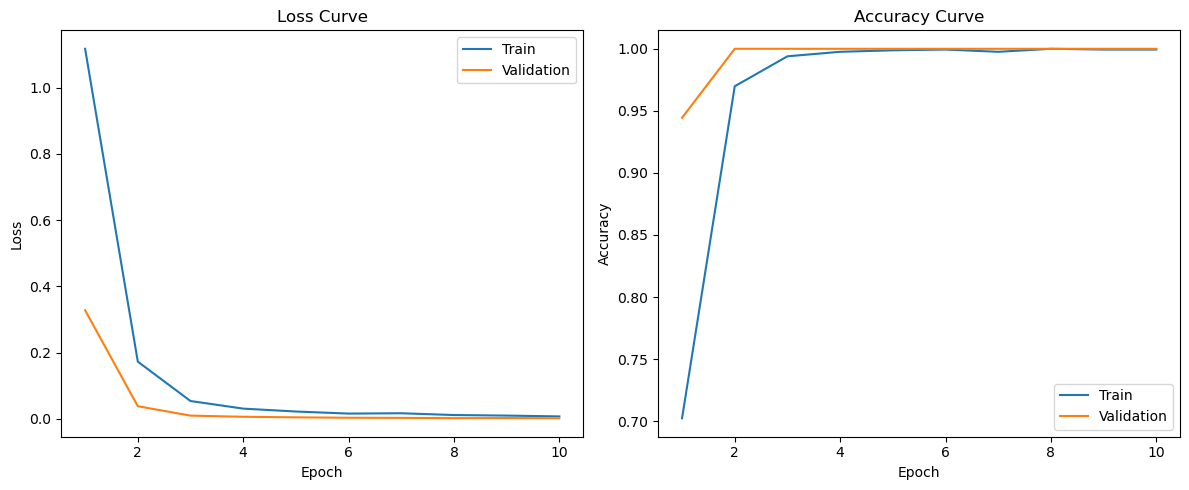

In [16]:
# Train the model

def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        correct_valid = 0
        total_valid = 0
        running_valid_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_accuracy = correct_valid / total_valid

        # Record metrics
        train_loss_list.append(epoch_loss)
        valid_loss_list.append(epoch_valid_loss)
        train_acc_list.append(train_accuracy)
        valid_acc_list.append(valid_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train')
    plt.plot(range(1, num_epochs + 1), valid_loss_list, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train')
    plt.plot(range(1, num_epochs + 1), valid_acc_list, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

train_model(model, criterion, optimizer, num_epochs=10)


In [17]:
# Evaluate the model

def evaluate_model(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate on test set
evaluate_model(model, test_loader)


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
